In [188]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

In [190]:
data = pd.read_excel(r'C:\Users\mbauer2\workspace\Uni\enterprise-ai-project\ImmmoWelt_Price_Guide\houses_to_buy_nbg_preprocessed.xlsx')

In [191]:
data.replace('""', np.nan, inplace=True)

In [192]:
data['DistributionType'].unique()

array(['BUY', 'COMPULSORY_AUCTION', 'BUY_AUCTION'], dtype=object)

In [156]:
data = data[data['DistributionType']=='BUY']

In [193]:
data = data[data['EstateType']=='HOUSE']

In [195]:
data

,Unnamed: 0,Object_price,LivingSpace,Rooms,ConstructionYear,ContactData,ZipCode,EstateType,DistributionType,abrissobjekt,...,tiefgarage,unterkellert,vermietet,vollerschlossen,wachdienst,wanne,wasch_trockenraum,wg_geeignet,wintergarten,zentralheizung
1,1,913800,163.00,7.0,2021.0,"{""companyName"": ""Lechner Massivhaus GmbH"", ""ad...",90455,HOUSE,BUY,0,...,0,1,0,0,0,1,0,0,0,0
2,2,850000,124.00,5.0,2021.0,"{""companyName"": ""Lechner Massivhaus GmbH"", ""ad...",90455,HOUSE,BUY,0,...,0,1,0,0,0,1,0,0,0,0
4,4,890600,163.00,7.0,2021.0,"{""companyName"": ""Lechner Massivhaus GmbH"", ""ad...",90455,HOUSE,BUY,0,...,0,1,0,0,0,1,0,0,0,0
6,6,860000,200.00,13.0,1970.0,"{""companyName"": ""Immobilien Brewer"", ""address""...",90427,HOUSE,BUY,0,...,0,0,0,0,0,0,0,0,0,1
7,7,559000,157.56,5.0,1973.0,"{""companyName"": ""Angerm\u00fcller Immobilien M...",90473,HOUSE,BUY,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,381,1400000,178.00,7.0,1978.0,"{""companyName"": ""FALCON Immobilien"", ""address""...",90475,HOUSE,BUY,0,...,0,0,0,0,0,0,0,0,0,1
382,382,1390000,184.00,15.0,NaN,"{""companyName"": ""EURAG GmbH"", ""address"": {""cit...",90431,HOUSE,BUY,0,...,0,0,0,0,0,0,0,0,0,0
383,383,695000,118.00,4.0,1958.0,"{""companyName"": ""L\u00f6w Immobilien GmbH"", ""a...",90455,HOUSE,BUY,0,...,0,1,0,0,0,0,0,0,0,0
384,384,4000000,522.40,35.0,2023.0,"{""companyName"": ""MGDN GmbH"", ""address"": {""city...",90475,HOUSE,BUY,0,...,0,1,0,0,0,0,0,0,0,0


In [194]:
data['ConstructionYear'].isnull().sum()
print(data.isnull().sum())

Unnamed: 0            0
Object_price          0
LivingSpace           0
Rooms                 0
ConstructionYear     33
                     ..
wanne                 0
wasch_trockenraum     0
wg_geeignet           0
wintergarten          0
zentralheizung        0
Length: 113, dtype: int64


In [196]:
data.dropna(inplace=True)
data["LivingSpace"] = pd.to_numeric(data["LivingSpace"], errors="coerce")
data["Rooms"] = pd.to_numeric(data["Rooms"], errors="coerce")
data.dropna(subset=['ConstructionYear'], inplace=True)
data.dropna(subset=['Object_price'], inplace=True)
data.dropna(subset=['Rooms'], inplace=True)
data.dropna(subset=['LivingSpace'], inplace=True)
data.drop('ContactData', axis=1, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)
#data.drop('Object_currency', axis=1, inplace=True)
#data.drop('Url', axis=1, inplace=True)
#data.drop('EstateType', axis=1, inplace=True)
#data.drop('DistributionType', axis=1, inplace=True)
data['ZipCode']= data['ZipCode'].astype(str)
data['LivingSpace']= data['LivingSpace'].astype(float)
data = data.reindex()

In [197]:
data

,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abrissobjekt,abstellraum,alarmanlage,...,tiefgarage,unterkellert,vermietet,vollerschlossen,wachdienst,wanne,wasch_trockenraum,wg_geeignet,wintergarten,zentralheizung
1,913800,163.00,7.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,850000,124.00,5.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,890600,163.00,7.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
6,860000,200.00,13.0,1970.0,90427,HOUSE,BUY,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,559000,157.56,5.0,1973.0,90473,HOUSE,BUY,0,1,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,475000,120.00,5.0,1966.0,90469,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,1,0,0,1
381,1400000,178.00,7.0,1978.0,90475,HOUSE,BUY,0,0,0,...,0,0,0,0,0,0,0,0,0,1
383,695000,118.00,4.0,1958.0,90455,HOUSE,BUY,0,1,0,...,0,1,0,0,0,0,0,0,0,0
384,4000000,522.40,35.0,2023.0,90475,HOUSE,BUY,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [198]:
print(data.isnull().sum())

Object_price         0
LivingSpace          0
Rooms                0
ConstructionYear     0
ZipCode              0
                    ..
wanne                0
wasch_trockenraum    0
wg_geeignet          0
wintergarten         0
zentralheizung       0
Length: 111, dtype: int64


In [199]:
data = data.reset_index(drop=True)

In [200]:
data

,Object_price,LivingSpace,Rooms,ConstructionYear,ZipCode,EstateType,DistributionType,abrissobjekt,abstellraum,alarmanlage,...,tiefgarage,unterkellert,vermietet,vollerschlossen,wachdienst,wanne,wasch_trockenraum,wg_geeignet,wintergarten,zentralheizung
0,913800,163.00,7.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,850000,124.00,5.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,890600,163.00,7.0,2021.0,90455,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,860000,200.00,13.0,1970.0,90427,HOUSE,BUY,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,559000,157.56,5.0,1973.0,90473,HOUSE,BUY,0,1,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,475000,120.00,5.0,1966.0,90469,HOUSE,BUY,0,0,0,...,0,1,0,0,0,1,1,0,0,1
330,1400000,178.00,7.0,1978.0,90475,HOUSE,BUY,0,0,0,...,0,0,0,0,0,0,0,0,0,1
331,695000,118.00,4.0,1958.0,90455,HOUSE,BUY,0,1,0,...,0,1,0,0,0,0,0,0,0,0
332,4000000,522.40,35.0,2023.0,90475,HOUSE,BUY,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [201]:
y = data['Object_price']
X = data.drop('Object_price', axis=1)
print(y.head())
print(X.head())

0    913800
1    850000
2    890600
3    860000
4    559000
Name: Object_price, dtype: int64
   LivingSpace  Rooms  ConstructionYear ZipCode EstateType DistributionType  \
0       163.00    7.0            2021.0   90455      HOUSE              BUY   
1       124.00    5.0            2021.0   90455      HOUSE              BUY   
2       163.00    7.0            2021.0   90455      HOUSE              BUY   
3       200.00   13.0            1970.0   90427      HOUSE              BUY   
4       157.56    5.0            1973.0   90473      HOUSE              BUY   

   abrissobjekt  abstellraum  alarmanlage  als_ferienimmobilie_geeignet  ...  \
0             0            0            0                             0  ...   
1             0            0            0                             0  ...   
2             0            0            0                             0  ...   
3             0            0            0                             0  ...   
4             0            1    

In [202]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                  train_size=0.8, 
                                                  random_state = 42)

In [204]:
num_cols = [col for col in train_X.columns if train_X[col].dtype == 'float64']
cat_cols = [col for col in train_X.columns if train_X[col].dtype == 'object']
bin_cols = [col for col in train_X.columns if train_X[col].dtype == 'int64']


In [206]:
print(cat_cols)

['ZipCode', 'EstateType', 'DistributionType']


In [207]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(train_X[cat_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(val_X[cat_cols]).toarray()
X_test_categorical_xgb = encoder.transform(test_X[cat_cols]).toarray()
X_train_processed = np.concatenate([train_X[num_cols], X_train_categorical_xgb], axis=1)
X_valid_processed = np.concatenate([val_X[num_cols], X_valid_categorical_xgb], axis=1)
X_test_processed = np.concatenate([test_X[num_cols], X_test_categorical_xgb], axis=1)
X_train_processed = np.concatenate([train_X[bin_cols], X_train_processed], axis=1)
X_valid_processed = np.concatenate([val_X[bin_cols], X_valid_processed], axis=1)
X_test_processed = np.concatenate([test_X[bin_cols], X_test_processed], axis=1)

In [208]:
X_train_processed[0]

array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

In [210]:
model = xgb.XGBRegressor(eval_metric=['rmse', 'mae'], early_stopping_rounds=30)
model.fit(X=X_train_processed, 
          y=train_y,
          eval_set=[(X_valid_processed, val_y)],  # Liste mit Validierungsdaten und Zielvariablen
          verbose=True
)

preds= model.predict(X_test_processed)
#preds_apartment = preds[test_X['EstateType']=='APARTMENT']
#test_y_apartment = test_y[test_X['EstateType']=='APARTMENT']
#preds_House = preds[test_X['EstateType']=='HOUSE']
#test_y_House= test_y[test_X['EstateType']=='HOUSE']
#score_House = mean_absolute_error(test_y_House, preds_House)
score_House = mean_absolute_error(test_y, preds)

print("MAE House: {}".format(score_House))
#

[0]	validation_0-rmse:941477.70998	validation_0-mae:624589.11568
[1]	validation_0-rmse:767162.53962	validation_0-mae:456554.01273
[2]	validation_0-rmse:689774.32481	validation_0-mae:372836.64873
[3]	validation_0-rmse:617127.19596	validation_0-mae:321443.25347
[4]	validation_0-rmse:575695.31400	validation_0-mae:286418.79745
[5]	validation_0-rmse:561122.67247	validation_0-mae:268178.82292
[6]	validation_0-rmse:550250.73050	validation_0-mae:259753.68924
[7]	validation_0-rmse:541785.77163	validation_0-mae:256118.67708
[8]	validation_0-rmse:534538.68578	validation_0-mae:252110.99016
[9]	validation_0-rmse:529759.52963	validation_0-mae:250939.33565
[10]	validation_0-rmse:525007.03198	validation_0-mae:249684.61574
[11]	validation_0-rmse:520483.39640	validation_0-mae:248538.01736
[12]	validation_0-rmse:514981.58413	validation_0-mae:247793.49132
[13]	validation_0-rmse:514488.13591	validation_0-mae:247892.79630
[14]	validation_0-rmse:508419.50108	validation_0-mae:245021.41262
[15]	validation_0-rm

In [211]:
model2 = lgb.LGBMRegressor(metric=['rmse', 'mae'], early_stopping_rounds=30)
model2.fit(X=X_train_processed, 
          y=train_y,
          eval_set=[(X_valid_processed, val_y)], 
          verbose=True
)

preds= model2.predict(X_test_processed)
score = mean_absolute_error(test_y, preds)

print("MAE: {}".format(score))


[1]	valid_0's rmse: 784332	valid_0's l1: 444680
[2]	valid_0's rmse: 754054	valid_0's l1: 416815
[3]	valid_0's rmse: 727989	valid_0's l1: 391244
[4]	valid_0's rmse: 706052	valid_0's l1: 368737
[5]	valid_0's rmse: 685340	valid_0's l1: 347485
[6]	valid_0's rmse: 670248	valid_0's l1: 331511
[7]	valid_0's rmse: 655016	valid_0's l1: 318908
[8]	valid_0's rmse: 642316	valid_0's l1: 310487
[9]	valid_0's rmse: 631569	valid_0's l1: 305193
[10]	valid_0's rmse: 622663	valid_0's l1: 300427
[11]	valid_0's rmse: 615840	valid_0's l1: 296915
[12]	valid_0's rmse: 610167	valid_0's l1: 293409
[13]	valid_0's rmse: 604889	valid_0's l1: 290198
[14]	valid_0's rmse: 600331	valid_0's l1: 287422
[15]	valid_0's rmse: 596453	valid_0's l1: 285307
[16]	valid_0's rmse: 593568	valid_0's l1: 281941
[17]	valid_0's rmse: 590094	valid_0's l1: 279536
[18]	valid_0's rmse: 587420	valid_0's l1: 275845
[19]	valid_0's rmse: 585118	valid_0's l1: 273361
[20]	valid_0's rmse: 582800	valid_0's l1: 271168
[21]	valid_0's rmse: 581227	v

c:\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [212]:
n_estimators = [10, 50, 100, 200, 300, 400, 500]
train_maes = []
valid_maes = []
for n in n_estimators:
    
    rf_model = RandomForestRegressor(n_estimators=n, random_state=0)
    rf_model.fit(X_train_processed, train_y)

    
    preds_train_rf = rf_model.predict(X_train_processed)
    preds_valid_rf = rf_model.predict(X_valid_processed)

    
    train_mae = mean_absolute_error(train_y, preds_train_rf)
    valid_mae = mean_absolute_error(val_y, preds_valid_rf)

    
    train_maes.append(train_mae)
    valid_maes.append(valid_mae)

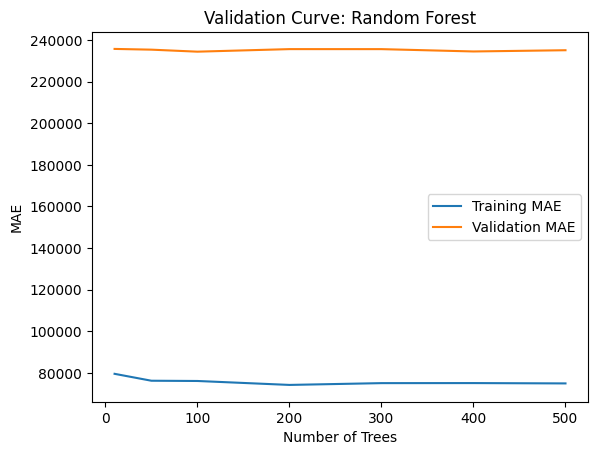

In [213]:
plt.plot(n_estimators, train_maes, label='Training MAE')
plt.plot(n_estimators, valid_maes, label='Validation MAE')
plt.xlabel('Number of Trees')
plt.ylabel('MAE')
plt.legend()
plt.title('Validation Curve: Random Forest')
plt.show()

In [214]:
rf_model = RandomForestRegressor(n_estimators=300, random_state=0)
rf_model.fit(X_train_processed, train_y)
preds_test_rf = rf_model.predict(X_test_processed)
score = mean_absolute_error(test_y, preds_test_rf)
print("MAE: {}".format(score))

MAE: 208073.47048092872
